In [ ]:
!pip install gensim nltk tensorflow scikit-learn imbalanced-learn keras-tuner optuna
!python -m nltk.downloader punkt stopwords wordnet
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.3 MB/s eta 0:00:00
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
--2025-01-13 14:18:42--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras_tuner as kt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import optuna
from google.colab import files
import io

In [ ]:
def preprocess_text(text):
    """
    Preprocess text by performing tokenization, lemmatization and stop word removal
    """
    # Initialize lemmatizer and get stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Convert to lowercase and tokenize
    tokens = word_tokenize(str(text).lower())

    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words]

    # Join tokens back into text
    return ' '.join(tokens)


In [ ]:
class EnhancedDocumentClassifier:
    def __init__(self, max_len=100, embedding_dim=300, embedding_type='glove'):
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.embedding_type = embedding_type
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=10000,
            preprocessor=preprocess_text
        )
        self.tokenizer = Tokenizer()
        self.label_encoder = LabelEncoder()
        self.rf_model = None
        self.deep_model = None

    def load_glove_embeddings(self):
        """
        Load GloVe embeddings
        """
        embeddings_index = {}
        with open(f'glove.6B.{self.embedding_dim}d.txt', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        return embeddings_index

    def create_embedding_matrix(self, embeddings_index):
        """
        Create embedding matrix for deep learning model
        """
        vocab_size = len(self.tokenizer.word_index) + 1
        embedding_matrix = np.zeros((vocab_size, self.embedding_dim))

        for word, i in self.tokenizer.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

        return embedding_matrix, vocab_size

    def build_deep_model(self, vocab_size, embedding_matrix=None):
        """
        Build deep learning model architecture
        """
        model = Sequential([
            Embedding(vocab_size, self.embedding_dim,
                     weights=[embedding_matrix] if embedding_matrix is not None else None,
                     input_length=self.max_len,
                     trainable=False if embedding_matrix is not None else True),
            Bidirectional(LSTM(128, return_sequences=True)),
            Bidirectional(LSTM(64)),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(len(self.label_encoder.classes_), activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def build_tunable_model(self, hp, vocab_size, embedding_matrix=None):
        """
        Build tunable deep learning model for hyperparameter optimization
        """
        model = Sequential()

        # Embedding layer
        model.add(Embedding(
            vocab_size,
            self.embedding_dim,
            weights=[embedding_matrix] if embedding_matrix is not None else None,
            input_length=self.max_len,
            trainable=False if embedding_matrix is not None else True
        ))

        # First Bidirectional LSTM layer with tunable units
        lstm_units_1 = hp.Int('lstm_units_1', min_value=32, max_value=256, step=32)
        model.add(Bidirectional(LSTM(lstm_units_1, return_sequences=True)))

        # Second Bidirectional LSTM layer with tunable units
        lstm_units_2 = hp.Int('lstm_units_2', min_value=16, max_value=128, step=16)
        model.add(Bidirectional(LSTM(lstm_units_2)))

        # Dense layers with tunable units and dropout
        dense_units_1 = hp.Int('dense_units_1', min_value=32, max_value=128, step=32)
        model.add(Dense(dense_units_1, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

        dense_units_2 = hp.Int('dense_units_2', min_value=16, max_value=64, step=16)
        model.add(Dense(dense_units_2, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

        # Output layer
        model.add(Dense(len(self.label_encoder.classes_), activation='softmax'))

        # Compile model with tunable learning rate
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def prepare_data(self, texts, labels):
        """
        Prepare text data for both traditional and deep learning models
        """
        # Preprocess all texts
        processed_texts = [preprocess_text(text) for text in texts]

        # TF-IDF vectorization for traditional model
        X_tfidf = self.tfidf_vectorizer.fit_transform(processed_texts)

        # Tokenization and padding for deep learning model
        self.tokenizer.fit_on_texts(processed_texts)
        sequences = self.tokenizer.texts_to_sequences(processed_texts)
        X_pad = pad_sequences(sequences, maxlen=self.max_len)

        # Encode labels
        y_encoded = self.label_encoder.fit_transform(labels)

        return X_tfidf, X_pad, y_encoded



    def train_traditional_model(self, X_train, y_train, tune=False):
        """
        Train traditional machine learning model (Random Forest) with optional hyperparameter tuning
        """
        if not tune:
            self.rf_model = RandomForestClassifier(
                n_estimators=100,
                max_depth=None,
                min_samples_split=2,
                min_samples_leaf=1,
                random_state=42
            )
            self.rf_model.fit(X_train, y_train)
            return self.rf_model

        # Define parameter grid for Random Forest
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': [None, 'sqrt', 0.1, 0.5, 0.9],
            'class_weight': ['balanced', None]
        }

        # Initialize base model
        base_rf = RandomForestClassifier(random_state=42)

        # Initialize RandomizedSearchCV
        rf_random = RandomizedSearchCV(
            estimator=base_rf,
            param_distributions=param_grid,
            n_iter=20,
            cv=3,
            verbose=2,
            random_state=42,
            n_jobs=-1,
            error_score='raise'  # Added for better error tracking
        )

        # Fit RandomizedSearchCV
        rf_random.fit(X_train, y_train)

        print("\nBest parameters found for Random Forest:")
        print(rf_random.best_params_)

        self.rf_model = rf_random.best_estimator_
        return self.rf_model

    def train_deep_model(self, X_train, y_train, X_val, y_val, tune=False):
        """
        Train deep learning model with optional hyperparameter tuning
        """
        if self.embedding_type == 'glove':
            embeddings_index = self.load_glove_embeddings()
            embedding_matrix, vocab_size = self.create_embedding_matrix(embeddings_index)
        else:
            embedding_matrix, vocab_size = None, len(self.tokenizer.word_index) + 1

        if not tune:
            self.deep_model = self.build_deep_model(vocab_size, embedding_matrix)
            callbacks = [
                EarlyStopping(patience=5, restore_best_weights=True),
                ReduceLROnPlateau(factor=0.2, patience=3)
            ]

            history = self.deep_model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=50,
                batch_size=32,
                callbacks=callbacks
            )

            return history

        # Initialize Keras Tuner
        tuner = kt.RandomSearch(
            lambda hp: self.build_tunable_model(hp, vocab_size, embedding_matrix),
            objective='val_accuracy',
            max_trials=2,
            directory='keras_tuner',
            project_name='document_classifier'
        )

        # Callbacks for training
        callbacks = [
            EarlyStopping(patience=5, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.2, patience=3)
        ]

        # Search for best hyperparameters
        tuner.search(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=30,
            callbacks=callbacks
        )

        print("\nBest hyperparameters found for Deep Learning model:")
        print(tuner.get_best_hyperparameters()[0].values)

        # Get the best model
        self.deep_model = tuner.get_best_models()[0]

        # Train the best model
        history = self.deep_model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=32,
            callbacks=callbacks
        )

        return history

    def evaluate_models(self, X_tfidf_test, X_pad_test, y_test):
        """
        Evaluate both models and return metrics
        """
        results = {}

        if self.rf_model is not None:
            rf_pred = self.rf_model.predict(X_tfidf_test)
            results['traditional'] = {
                'classification_report': classification_report(y_test, rf_pred),
                'confusion_matrix': confusion_matrix(y_test, rf_pred)
            }

        if self.deep_model is not None:
            deep_pred = np.argmax(self.deep_model.predict(X_pad_test), axis=1)
            results['deep_learning'] = {
                'classification_report': classification_report(y_test, deep_pred),
                'confusion_matrix': confusion_matrix(y_test, deep_pred)
            }

        return results

    def plot_training_history(self, history):
        """
        Plot training history for deep learning model
        """
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def visualize_class_distribution(self, labels):
        """
        Visualize class distribution
        """
        plt.figure(figsize=(10, 6))
        sns.countplot(x=labels)
        plt.title('Class Distribution')
        plt.xticks(rotation=45)
        plt.show()

In [ ]:
print("Please upload your excel file containing the text documents and labels.")
uploaded = files.upload()

# Get the filename of the uploaded file
filename = next(iter(uploaded))
df = pd.read_excel(io.BytesIO(uploaded[filename]))

Please upload your excel file containing the text documents and labels.


Saving Document_Classifier_Dataset.xlsx to Document_Classifier_Dataset.xlsx


In [ ]:
print("\nDataset Info:")
print(f"Number of documents: {len(df)}")
print("\nColumn names:", df.columns.tolist())



Dataset Info:
Number of documents: 3000

Column names: ['ID', 'Text', 'Category']


In [ ]:
print("\nPlease enter the column names from your dataset:")
text_column = input("Enter the name of the column containing the text documents: ")
label_column = input("Enter the name of the column containing the labels: ")



Please enter the column names from your dataset:
Enter the name of the column containing the text documents: Text
Enter the name of the column containing the labels: Category


In [ ]:
# Initialize classifier
classifier = EnhancedDocumentClassifier(
    max_len=100,
    embedding_dim=300,
    embedding_type='glove'
)


Visualizing class distribution...


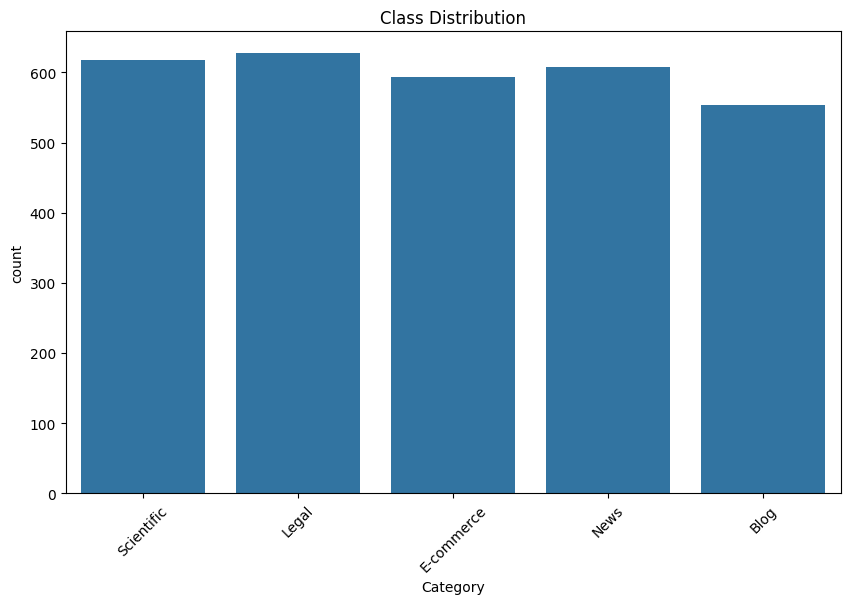

In [ ]:
print("\nVisualizing class distribution...")
classifier.visualize_class_distribution(df[label_column])


In [ ]:
!python -m nltk.downloader punkt_tab

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Prepare data
print("\nPreparing data...")
X_tfidf, X_pad, y_encoded = classifier.prepare_data(df[text_column], df[label_column])



Preparing data...


In [ ]:
# Split data
X_tfidf_train, X_tfidf_test, X_pad_train, X_pad_test, y_train, y_test = train_test_split(
    X_tfidf, X_pad, y_encoded, test_size=0.2, random_state=42
)

X_tfidf_train, X_tfidf_val, X_pad_train, X_pad_val, y_train, y_val = train_test_split(
    X_tfidf_train, X_pad_train, y_train, test_size=0.2, random_state=42
)

Trial 2 Complete [00h 48m 06s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 01h 31m 47s

Best hyperparameters found for Deep Learning model:
{'lstm_units_1': 256, 'lstm_units_2': 80, 'dense_units_1': 32, 'dropout_1': 0.4, 'dense_units_2': 32, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.0004055961741658466}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9823 - loss: 0.1168 - val_accuracy: 1.0000 - val_loss: 0.0058 - learning_rate: 4.0560e-04
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9873 - loss: 0.0792 - val_accuracy: 0.9979 - val_loss: 0.0055 - learning_rate: 4.0560e-04
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9932 - loss: 0.0601 - val_accuracy: 0.9979 - val_loss: 0.0088 - learning_rate: 4.0560e-04
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9983 - loss: 0.0433 - val_accuracy: 1.0000 - val_loss: 0.0014 - learning_rate: 4.0560e-04
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.9934 - loss: 0.0389 - val_accuracy: 0.9979 - val_loss: 0.0101 - learning_rate: 4.0560e-04
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9934 - loss: 0.0389 - val_accuracy: 0.9979 - val_loss: 0.0120 - learning_rate: 4.0560e-04
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9965 - loss: 0.02

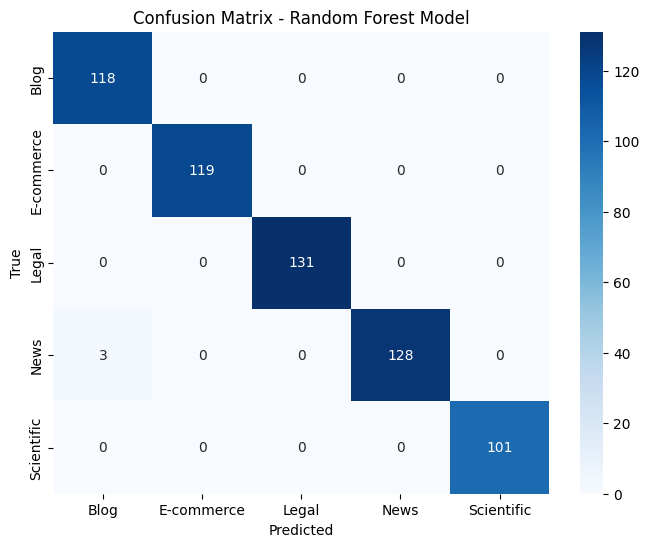


BiLSTM Model Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00       119
           2       1.00      1.00      1.00       131
           3       1.00      1.00      1.00       131
           4       1.00      1.00      1.00       101

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



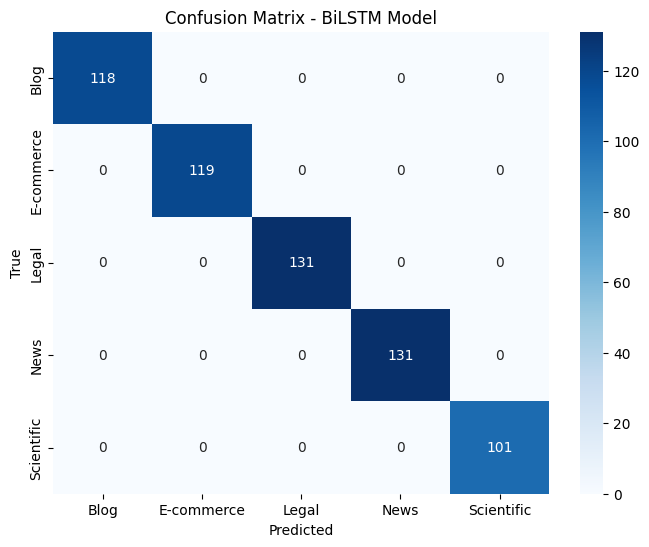

In [ ]:
print("\nWhich models would you like to train?")
train_traditional = input("Train traditional model (Random Forest)? (yes/no): ").lower() == 'yes'
train_deep = input("Train deep learning model (BiLSTM)? (yes/no): ").lower() == 'yes'
use_tuning = input("Use hyperparameter tuning? (yes/no): ").lower() == 'yes'

# Train models based on user choice
results = {}
history = None

if train_traditional:
    print("\nTraining traditional model (Random Forest)...")
    print("This may take a while if hyperparameter tuning is enabled...")
    rf_model = classifier.train_traditional_model(X_tfidf_train, y_train, tune=use_tuning)

    # Get feature importance
    if rf_model is not None:
        feature_importance = pd.DataFrame({
            'feature': classifier.tfidf_vectorizer.get_feature_names_out(),
            'importance': rf_model.feature_importances_
        })
        feature_importance = feature_importance.sort_values('importance', ascending=False)

        # Plot top 20 most important features
        plt.figure(figsize=(12, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
        plt.title('Top 20 Most Important Features (Random Forest)')
        plt.tight_layout()
        plt.show()

if train_deep:
    print("\nTraining deep learning model (BiLSTM)...")
    print("This may take a while if hyperparameter tuning is enabled...")
    history = classifier.train_deep_model(
        X_pad_train, y_train,
        X_pad_val, y_val,
        tune=use_tuning
    )

# Evaluate models and plot results
print("\nEvaluating models...")
evaluation_results = classifier.evaluate_models(X_tfidf_test, X_pad_test, y_test)
if train_traditional:
    print("\nRandom Forest Model Results:")
    print(evaluation_results['traditional']['classification_report'])

    # Plot confusion matrix for traditional model
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        evaluation_results['traditional']['confusion_matrix'],
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=classifier.label_encoder.classes_,
        yticklabels=classifier.label_encoder.classes_
    )
    plt.title('Confusion Matrix - Random Forest Model')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

if train_deep:
    print("\nBiLSTM Model Results:")
    print(evaluation_results['deep_learning']['classification_report'])

    # Plot confusion matrix for deep learning model
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        evaluation_results['deep_learning']['confusion_matrix'],
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=classifier.label_encoder.classes_,
        yticklabels=classifier.label_encoder.classes_
    )
    plt.title('Confusion Matrix - BiLSTM Model')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

